In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
def generate_sbm_multiclass(num_nodes=150, num_classes=3, seed=0):
    np.random.seed(seed)

    # tamaños de bloque
    nodes_per_class = num_nodes // num_classes
    sizes = [nodes_per_class] * num_classes
    if num_nodes % num_classes > 0:
        sizes[-1] += num_nodes % num_classes

    # heterofilia: p_out > p_in
    p_in, p_out = 0.02, 0.25
    probs = np.full((num_classes, num_classes), p_out, dtype=float)
    np.fill_diagonal(probs, p_in)

    G = nx.stochastic_block_model(sizes, probs, seed=seed)

    # nos quedamos con la componente conexa más grande
    if not nx.is_connected(G):
        largest = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest).copy()
        G = nx.convert_node_labels_to_integers(G)

    edges = np.array(list(G.edges()), dtype=np.int64)
    y = np.array([G.nodes[i]['block'] for i in range(G.number_of_nodes())], dtype=np.int64)

    return edges, y


In [3]:
def make_gaussians_multiclass(y, num_classes=3, seed=0):
    rng = np.random.RandomState(seed)
    n = len(y)
    X = np.zeros((n, 2), dtype=np.float32)

    # centros en eje x
    centers = np.linspace(-3, 3, num_classes)
    for i in range(n):
        mean = np.array([centers[y[i]], 0.0])
        X[i] = rng.normal(mean, 1.5)
    return X.astype(np.float32)


In [4]:
class PhiO2(nn.Module):
    """
    Φ: (x_v, x_u) -> F_{v->e}, F_{u->e} en O(2)
    Devolvemos rotaciones 2D parametrizadas por un ángulo.
    """
    def __init__(self, in_dim, hidden_dim=32):
        super().__init__()
        # dos MLPs distintos para no imponer simetría
        self.mlp_v = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.mlp_u = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x_v, x_u):
        """
        x_v, x_u: [m, 2]
        devuelve:
            F_ve, F_ue: [m, 2, 2] matrices ortogonales
        """
        inp = torch.cat([x_v, x_u], dim=-1)  # [m, 4]

        theta_v = self.mlp_v(inp).squeeze(-1)  # [m]
        theta_u = self.mlp_u(inp).squeeze(-1)  # [m]

        cos_v = torch.cos(theta_v)
        sin_v = torch.sin(theta_v)
        cos_u = torch.cos(theta_u)
        sin_u = torch.sin(theta_u)

        # construimos rotaciones 2x2
        F_ve = torch.stack([
            torch.stack([cos_v, -sin_v], dim=-1),
            torch.stack([sin_v,  cos_v], dim=-1)
        ], dim=-2)  # [m, 2, 2]

        F_ue = torch.stack([
            torch.stack([cos_u, -sin_u], dim=-1),
            torch.stack([sin_u,  cos_u], dim=-1)
        ], dim=-2)  # [m, 2, 2]

        return F_ve, F_ue


In [5]:
def build_sheaf_laplacian_orth(n_nodes, edges, F_ve, F_ue):
    """
    n_nodes: número de nodos
    edges: [m, 2] (v,u)
    F_ve, F_ue: [m, 2, 2] ortogonales

    Devuelve ∆_F de tamaño (2n) x (2n)
    """
    device = F_ve.device
    d = 2
    m = edges.shape[0]

    # L_F: matriz de bloques 2x2
    L = torch.zeros((n_nodes * d, n_nodes * d), device=device)

    for e in range(m):
        v = int(edges[e, 0].item())
        u = int(edges[e, 1].item())
        Fv = F_ve[e]  # [2,2]
        Fu = F_ue[e]

        # índices de bloque
        vs = slice(v * d, (v + 1) * d)
        us = slice(u * d, (u + 1) * d)

        # bloques como en Def. 2 / Figura 3
        # L[v,v] += F_v^T F_v = I
        L[vs, vs] = L[vs, vs] + Fv.T @ Fv
        L[us, us] = L[us, us] + Fu.T @ Fu

        # L[v,u] -= F_v^T F_u
        L[vs, us] = L[vs, us] - Fv.T @ Fu
        L[us, vs] = L[us, vs] - Fu.T @ Fv

    # D es block-diagonal, cada bloque = degree(v)*I_2 (por ortogonalidad)
    deg = torch.zeros(n_nodes, device=device)
    for e in range(m):
        v = int(edges[e, 0].item())
        u = int(edges[e, 1].item())
        deg[v] += 1.0
        deg[u] += 1.0

    # vector con d veces cada escala
    eps = 1e-6
    s = 1.0 / torch.sqrt(torch.clamp(deg, min=eps))  # [n]
    s_rep = torch.repeat_interleave(s, repeats=d)     # [2n]

    # D^{-1/2} L D^{-1/2} == diag(s_rep) @ L @ diag(s_rep)
    S = torch.diag(s_rep)
    Delta = S @ L @ S
    return Delta


In [6]:
def diffuse(X0, Delta, T):
    """
    X0: [n, 2]
    Delta: [2n, 2n]
    """
    n, d = X0.shape
    assert d == 2
    x_flat = X0.reshape(n * d, 1)  # [2n,1]

    for _ in range(T):
        x_flat = x_flat - Delta @ x_flat

    X_T = x_flat.view(n, d)
    return X_T


In [7]:
class O2SheafModel(nn.Module):
    def __init__(self, in_features, num_classes, hidden_phi=32, T=20):
        super().__init__()
        self.T = T
        self.phi = PhiO2(in_dim=2 * in_features, hidden_dim=hidden_phi)
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, X0, edges):
        n = X0.shape[0]
        v = edges[:, 0]
        u = edges[:, 1]

        F_ve, F_ue = self.phi(X0[v], X0[u])
        Delta = build_sheaf_laplacian_orth(n, edges, F_ve, F_ue)
        X_T = diffuse(X0, Delta, self.T)
        logits = self.classifier(X_T)
        return logits, X_T, Delta, (F_ve, F_ue)


    def get_diffusion_trajectory(self, X0, edges):
        self.eval()
        with torch.no_grad():
            n = X0.shape[0]

            # 1. Construir sheaf y Delta una sola vez (como en forward)
            v = edges[:, 0]
            u = edges[:, 1]
            F_ve, F_ue = self.phi(X0[v], X0[u])
            Delta = build_sheaf_laplacian_orth(n, edges, F_ve, F_ue)

            # 2. Aplanar X para difundir (porque Δ es de tamaño 2n×2n)
            X = X0.reshape(n * 2, 1)

            # 3. Guardar paso inicial
            trajectory = [X0.detach().cpu().numpy()]  # [n,2]

            # 4. Simular cada paso de difusión
            for _ in range(self.T):
                X = X - Delta @ X
                X_t = X.view(n, 2).detach().cpu().numpy()
                trajectory.append(X_t)

            return trajectory


In [8]:
# ----- datos -----
NUM_CLASSES = 3
edges_np, y_np = generate_sbm_multiclass(num_nodes=210,
                                         num_classes=NUM_CLASSES,
                                         seed=0)
X_np = make_gaussians_multiclass(y_np, num_classes=NUM_CLASSES, seed=0)

edges = torch.tensor(edges_np, dtype=torch.long)
X0 = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.long)

# ----- modelo -----
model = O2SheafModel(in_features=2, num_classes=NUM_CLASSES,
                     hidden_phi=32, T=20)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

print("Entrenando NSD con O(2)-bundle (d=2, C=3)...")

for epoch in range(1500):
    model.train()
    optimizer.zero_grad()

    logits, X_T, Delta, _ = model(X0, edges)
    loss = criterion(logits, y)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        with torch.no_grad():
            pred = logits.argmax(dim=-1)
            acc = (pred == y).float().mean().item()
        print(f"Epoch {epoch:03d} | Loss={loss.item():.4f} | Acc={acc:.3f}")


Entrenando NSD con O(2)-bundle (d=2, C=3)...
Epoch 000 | Loss=1.1356 | Acc=0.014
Epoch 020 | Loss=1.0709 | Acc=0.457
Epoch 040 | Loss=0.9762 | Acc=0.486
Epoch 060 | Loss=0.8580 | Acc=0.662
Epoch 080 | Loss=0.7641 | Acc=0.733
Epoch 100 | Loss=0.7010 | Acc=0.767
Epoch 120 | Loss=0.6490 | Acc=0.767
Epoch 140 | Loss=0.6070 | Acc=0.781
Epoch 160 | Loss=0.5619 | Acc=0.805
Epoch 180 | Loss=0.5369 | Acc=0.824
Epoch 200 | Loss=0.5104 | Acc=0.833
Epoch 220 | Loss=0.4903 | Acc=0.843
Epoch 240 | Loss=0.4720 | Acc=0.852
Epoch 260 | Loss=0.4551 | Acc=0.857
Epoch 280 | Loss=0.4386 | Acc=0.876
Epoch 300 | Loss=0.4241 | Acc=0.890
Epoch 320 | Loss=0.4076 | Acc=0.890
Epoch 340 | Loss=0.3985 | Acc=0.881
Epoch 360 | Loss=0.3796 | Acc=0.890
Epoch 380 | Loss=0.3751 | Acc=0.905
Epoch 400 | Loss=0.3592 | Acc=0.895
Epoch 420 | Loss=0.3478 | Acc=0.900
Epoch 440 | Loss=0.3389 | Acc=0.914
Epoch 460 | Loss=0.3307 | Acc=0.914
Epoch 480 | Loss=0.3247 | Acc=0.905
Epoch 500 | Loss=0.3163 | Acc=0.919
Epoch 520 | Loss=0.

Trayectoria obtenida con 21 pasos.


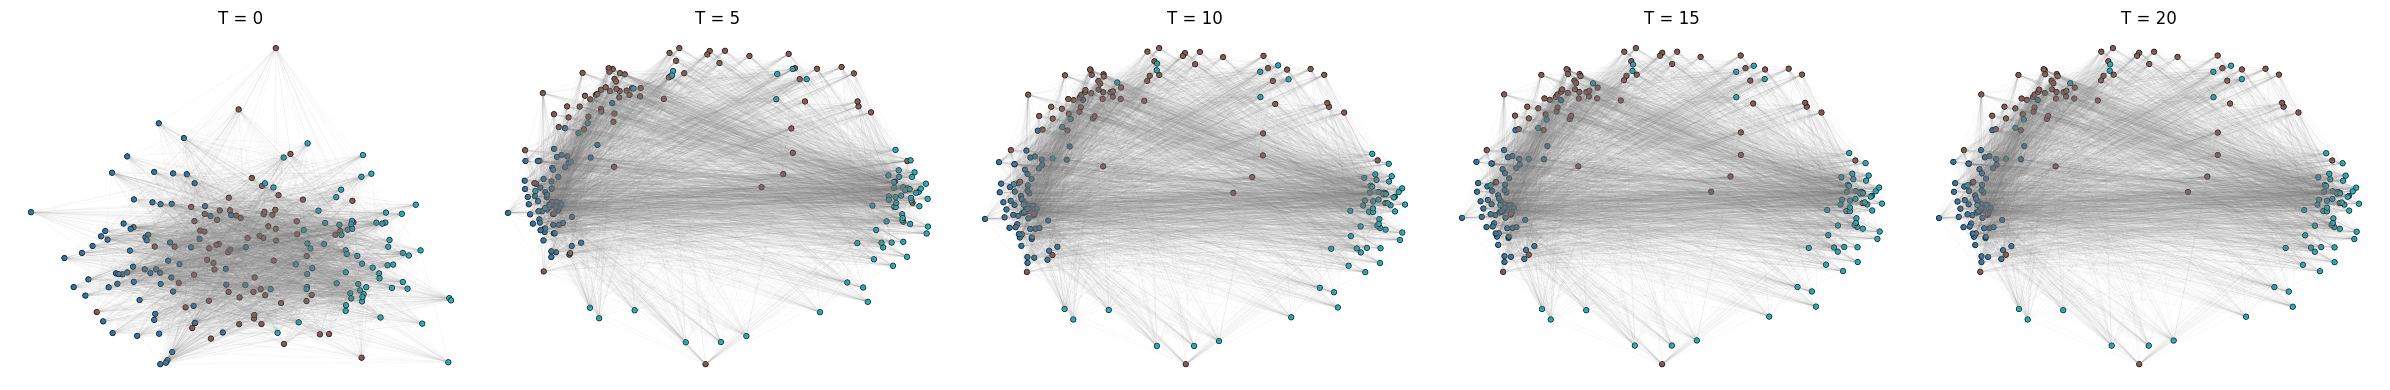

In [9]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import torch

# --- Generar datos de TEST (SBM heterofílico multiclass) ---
edges_test_np, labels_test = generate_sbm_multiclass(num_nodes=210, num_classes=3, seed=0)
X_test_np = make_gaussians_multiclass(labels_test, num_classes=3, seed=42)

edges_test_torch = torch.tensor(edges_test_np, dtype=torch.long)
X_test_torch = torch.tensor(X_test_np, dtype=torch.float32)

# --- Obtener trayectoria ---
trajectory = model.get_diffusion_trajectory(X_test_torch, edges_test_torch)
print(f"Trayectoria obtenida con {len(trajectory)} pasos.")

# --- Tiempos que queremos mostrar ---
times = [
    0,
    model.T // 4,
    model.T // 2,
    3 * model.T // 4,
    model.T
]

fig, axes = plt.subplots(1, len(times), figsize=(24, 4))

for i, t in enumerate(times):
    if t < len(trajectory):
        X_t = trajectory[t]            # (n,2)
        ax = axes[i]

        # A. Dibujar aristas
        start_points = X_t[edges_test_np[:, 0]]
        end_points   = X_t[edges_test_np[:, 1]]
        segments = np.stack((start_points, end_points), axis=1)
        lc = LineCollection(segments, colors='gray', alpha=0.1, linewidths=0.3)
        ax.add_collection(lc)

        # B. Dibujar nodos por clase
        ax.scatter(X_t[:, 0], X_t[:, 1],
                   c=labels_test, cmap='tab10', s=15,
                   edgecolors='k', linewidths=0.5)

        ax.set_title(f"T = {t}")
        ax.set_xticks([]); ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

plt.tight_layout()
plt.show()
